# Gelman's bioassay example without using MCMC

I found this example in "Bayesian Data Analysis" by A. Gelman, J.B. Carlin, H.S. Stern, D.B. Dunson, A.Vehtari and D.B. Rubin.  Here is my translation into python.

The Bioassay example is about evaluating LD50 tests. The drug dose is logarithmic.

In [1]:
import numpy as np
from scipy import integrate
from scipy import interpolate
import matplotlib.pylab as plt
%matplotlib inline

In [2]:
# Samples for each dose level
n_samples = 5 * np.ones(4, dtype=int)
# Log-dose
dose = np.array([-.86, -.3, -.05, .73])
deaths=np.array([0, 1, 3, 5])

Here are some function definitions. The definition of pobservation requires some explanation. pobservation is proportional to the posterior probability of alpha and beta given the observed data.  The model is that $logit(theta)=alpha+dose*beta$, where theta is the probablity of death for the log drug concentration dose.

$$\operatorname{logit}(p)=\log\left( \frac{p}{1-p} \right) =\log(p)-\log(1-p)=-\log\left( \frac{1}{p} - 1\right)$$

In order to use the function with alpha, beta being two-dimensional matrices and dose,obs_deaths and n being one-dimensional arrays, I was forced to interate over dose and then take the product over the first axis.  Let me know if there is an easier and more elegant way.

In [3]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def pobservation(alpha,beta,dose,obs_deaths,n):
    p=[]
    for ind_dose,i in zip(dose,range(len(dose))):
        theta=invlogit(alpha+beta*ind_dose)
        p.append(theta**obs_deaths[i]*(1-theta)**(n[i]-obs_deaths[i]))
    p=np.array(p)
    return np.prod(p,axis=0)

We also need to define a function to calculate the inverse cummulative distribution function

In [4]:
# calculate inverse cummulative distribution function for sampling
def inv_cdf(pdf,x):
    cdf_pdf=[integrate.simps(pdf[:i+1],x[:i+1]) for i in range(len(x)-1)]
    cdf_pdf=np.array([0.0]+cdf_pdf)
    cdf_pdf=cdf_pdf/cdf_pdf[-1]
    return interpolate.interp1d(cdf_pdf,x)

Now lets calculate the posterior probablity over a grid of points

In [5]:
delta = 0.1
alpha = np.arange(-5.0, 10.0+delta, delta)
beta = np.arange(-10.0, 40+delta, delta)
ALPHA, BETA = np.meshgrid(alpha, beta)
P = pobservation(ALPHA,BETA,dose,deaths,n_samples)

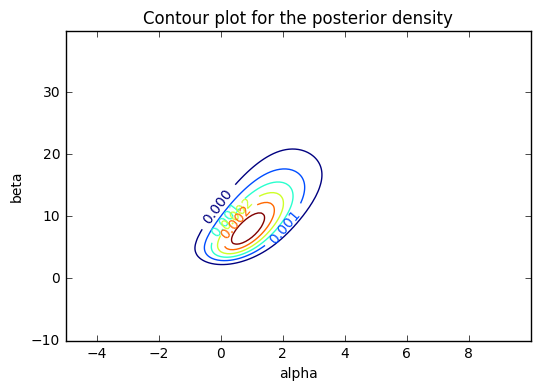

In [6]:
plt.figure()
CS = plt.contour(ALPHA, BETA, P)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Contour plot for the posterior density')
plt.xlabel('alpha')
plt.ylabel('beta')

we can now calculate the average alpha and beta distributions by averaging over the other direction

In [7]:
# average distributions
alpha_pro=np.mean(P,axis=0)
beta_pro=np.mean(P,axis=1)

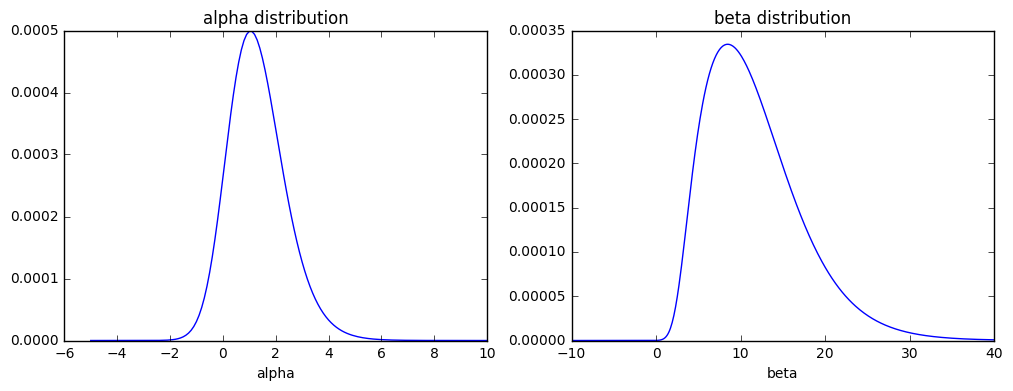

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
plt.plot(alpha,alpha_pro)
plt.xlabel('alpha')
plt.title('alpha distribution')
plt.subplot(1,2,2)
plt.plot(beta,beta_pro)
plt.xlabel('beta')
plt.title('beta distribution')

Now lets sample from this distribution by first randomly sampling from the average alpha distribution and then randomly sampling from the corresponding beta distribution. We sampling using the inverse-cdf method that is described in Gelman's book. 

In [9]:
n=1000
sample_alpha=np.random.random_sample(n)
sample_beta=np.random.random_sample(n)

inv_cdf_alpha=inv_cdf(alpha_pro,alpha)
alpha_sampling=inv_cdf_alpha(sample_alpha)

beta_sampling=[]
for alp,bet in zip(alpha_sampling,sample_beta):
    beta_dis=pobservation(alp,beta,dose,deaths,n_samples)
    b_sample=inv_cdf(beta_dis,beta)(bet)
    beta_sampling.append(b_sample)
beta_sampling=np.array(beta_sampling)

ld50=-alpha_sampling/beta_sampling

lets look at the calculated LD50 distribution

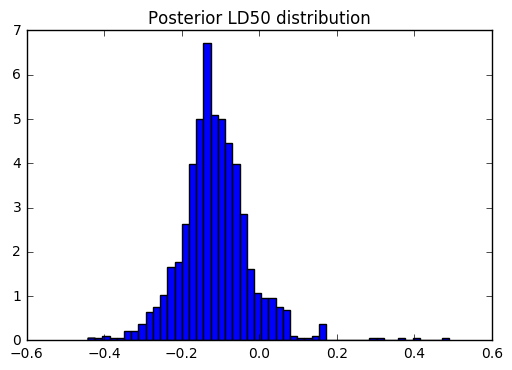

In [10]:
plt.figure()
plt.hist(ld50,bins=50,normed=True)
plt.title('Posterior LD50 distribution')